<a href="https://colab.research.google.com/github/shairal1/Image_Similarity/blob/main/image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Mounted at /gdrive


In [35]:
import skimage.io as io
from PIL import Image

In [36]:
from pathlib import Path
import os
artist_name = 'van_gogh_si'
#path = Path(f'/content/drive/MyDrive/dev_fest_art_recommendation/{artist_name}')
path=Path(f'/content')

# here urls.txt should appear
os.listdir(path)


['.config',
 '.ipynb_checkpoints',
 'urls.txt',
 'drive',
 'paintings',
 'sample_data']

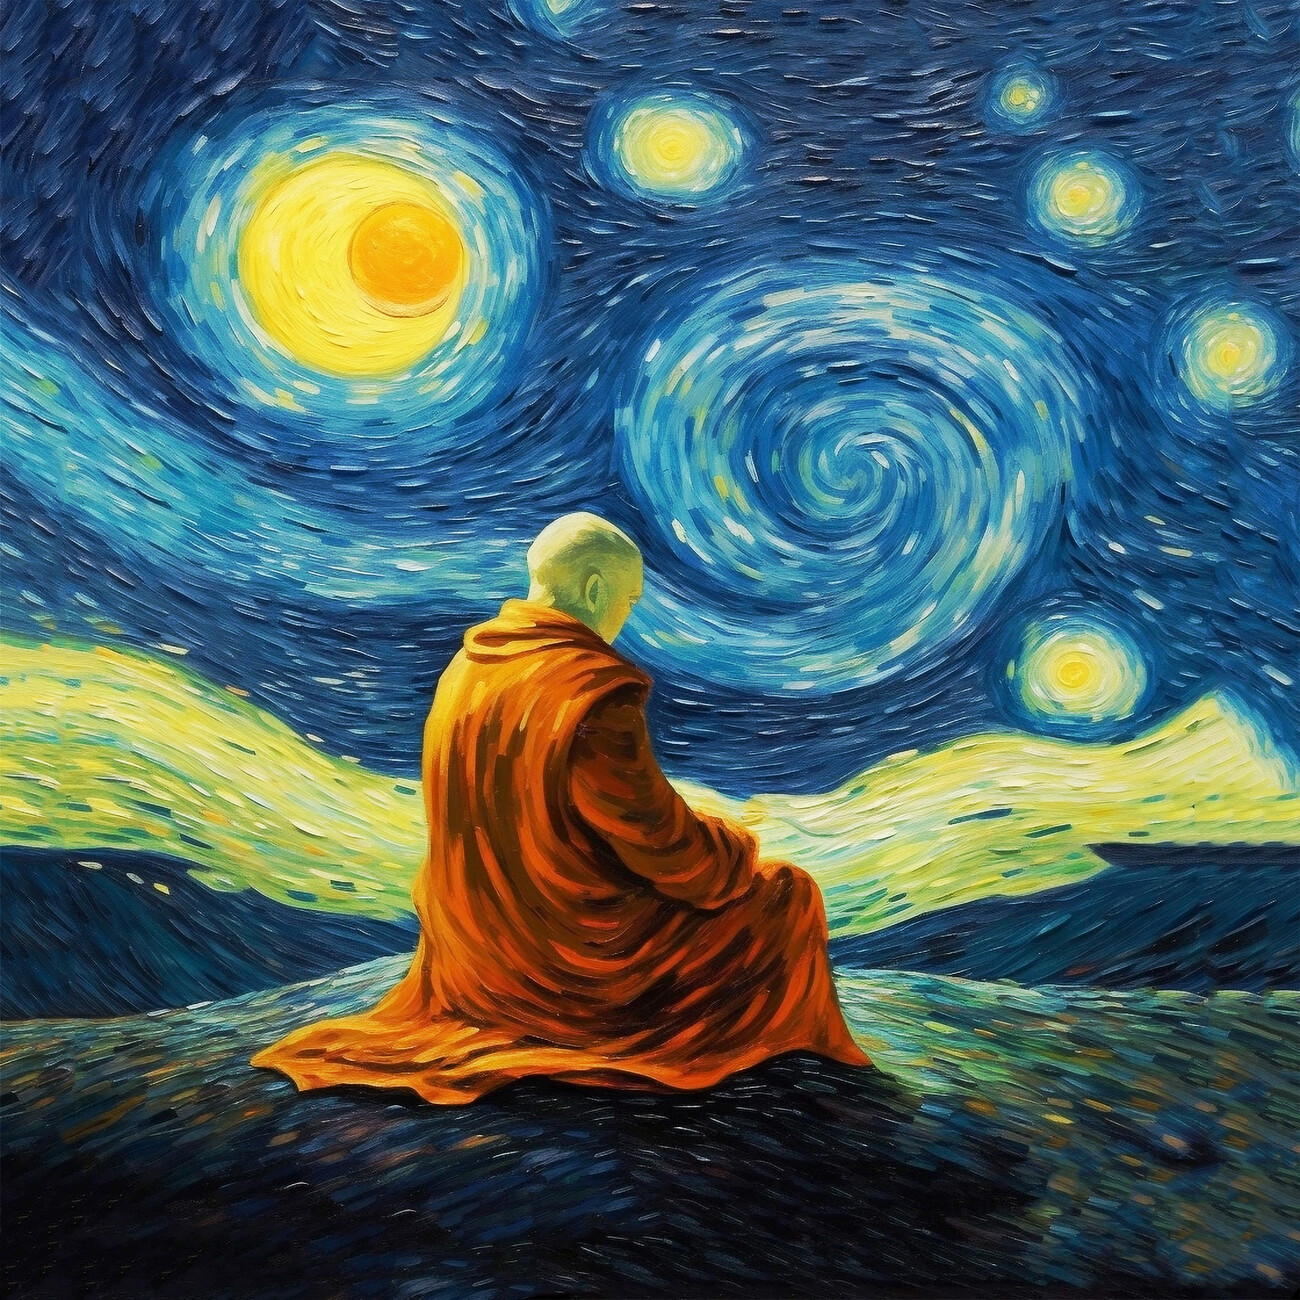

In [38]:
with open(path / 'urls.txt', 'r') as f:
   # https://stackoverflow.com/a/12330535/45963
  image_urls = f.read().splitlines()

# Here we should read a url
image_urls[2]


img_array =io.imread(image_urls[2])
#img_array

image = Image.fromarray(img_array).convert("RGB")
image


In [39]:
from PIL import Image
for i, url in enumerate(image_urls):
  print(i, url)
  try:
    img_array =io.imread(url)
    image = Image.fromarray(img_array).convert("RGB")
    filename = path/f'paintings/{artist_name}_{i}.jpg'
    image.save(filename)
  except Exception as e:
        print(f"Error processing image {i}: {e}")


0 https://static.standard.co.uk/s3fs-public/thumbnails/image/2019/03/05/11/sei26139543-1-0.jpg?width=1200&auto=webp&quality=75
1 https://cdn.britannica.com/78/43678-050-F4DC8D93/Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg
2 https://storage.googleapis.com/pod_public/1300/183916.jpg
3 https://www.vangoghstudio.com//Files/6/102000/102147/ProductPhotos/Source/1910986836.jpg
4 https://www.vincentvangogh.org/images/self-portrait.jpg
Error processing image 4: HTTP Error 403: Forbidden
5 https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Vincent_Willem_van_Gogh_127.jpg/270px-Vincent_Willem_van_Gogh_127.jpg
6 https://archive.artic.edu/van-gogh-bedrooms/VanGogh--Bedroom--1889--MuseedOrsayParis--1400.jpg
7 http://masterpiecebynumbers.com/cdn/shop/products/Van_Gogh_-_Sunflowers.jpg?v=1586183427
8 https://i.pinimg.com/736x/b7/0a/43/b70a43a7884bdcc6a82cad39bc434db9.jpg
9 https://images.saatchiart.com/saatchi/1732314/art/9283361/8346469-HSC00923-7.jpg
Error processing image 9: HTTP Error

In [ ]:
#os.mkdir(path/'paintings')
#filename1 = path/f'paintings/{artist_name}_1.jpg'
#image.save(filename1)


In [40]:

# https://github.com/christiansafka/img2vec
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048,
    }

    def __init__(self, cuda=False, model='resnet-34', layer='default',
                 layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[:, :]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(1, self.layer_output_size)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[0, :]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-34':
            model = models.resnet34(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)


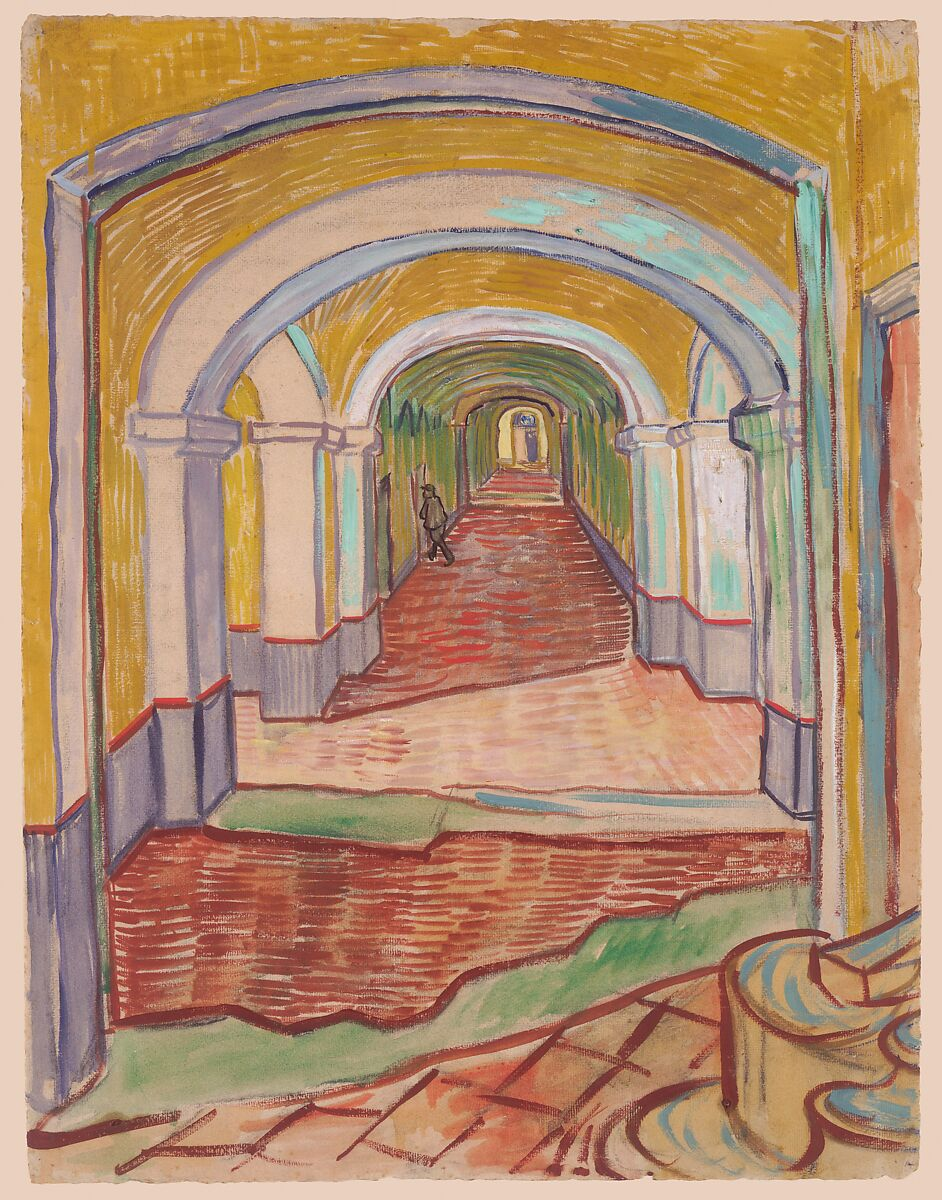

In [41]:
image

In [43]:
    img_array =io.imread(url)
    image = Image.fromarray(img_array).convert("RGB")
    filename = path/f'paintings/{artist_name}_{i}.jpg'
    #filename = path/{artist_name}_{i}.jpg
    image.save(filename)


In [46]:
paintings_embedded_dict=dict()
for f in os.listdir( path/f'paintings'):
  print(f)
  image = Image.open(f"/content/paintings/{f}")
  img2vec = Img2Vec()
  embedding = img2vec.get_vec(image)
  paintings_embedded_dict[f]=embedding


van_gogh_si_175.jpg


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 152MB/s]


van_gogh_si_269.jpg
van_gogh_si_331.jpg
van_gogh_si_228.jpg
van_gogh_si_141.jpg
van_gogh_si_160.jpg
van_gogh_si_263.jpg
van_gogh_si_38.jpg
van_gogh_si_42.jpg
van_gogh_si_277.jpg
van_gogh_si_393.jpg
van_gogh_si_172.jpg
van_gogh_si_71.jpg
van_gogh_si_278.jpg
van_gogh_si_262.jpg
van_gogh_si_357.jpg
van_gogh_si_206.jpg
van_gogh_si_215.jpg
van_gogh_si_336.jpg
van_gogh_si_126.jpg
van_gogh_si_151.jpg
van_gogh_si_257.jpg
van_gogh_si_163.jpg
van_gogh_si_223.jpg
van_gogh_si_369.jpg
van_gogh_si_302.jpg
van_gogh_si_117.jpg
van_gogh_si_314.jpg
van_gogh_si_225.jpg
van_gogh_si_224.jpg
van_gogh_si_375.jpg
van_gogh_si_394.jpg
van_gogh_si_204.jpg
van_gogh_si_70.jpg
van_gogh_si_380.jpg
van_gogh_si_29.jpg
van_gogh_si_231.jpg
van_gogh_si_354.jpg
van_gogh_si_180.jpg
van_gogh_si_185.jpg
van_gogh_si_347.jpg
van_gogh_si_11.jpg
van_gogh_si_60.jpg
van_gogh_si_209.jpg
van_gogh_si_125.jpg
van_gogh_si_261.jpg
van_gogh_si_372.jpg
van_gogh_si_310.jpg
van_gogh_si_62.jpg
van_gogh_si_341.jpg
van_gogh_si_254.jpg
van_gogh

In [47]:
paintings_embedded_dict.keys()

dict_keys(['van_gogh_si_175.jpg', 'van_gogh_si_269.jpg', 'van_gogh_si_331.jpg', 'van_gogh_si_228.jpg', 'van_gogh_si_141.jpg', 'van_gogh_si_160.jpg', 'van_gogh_si_263.jpg', 'van_gogh_si_38.jpg', 'van_gogh_si_42.jpg', 'van_gogh_si_277.jpg', 'van_gogh_si_393.jpg', 'van_gogh_si_172.jpg', 'van_gogh_si_71.jpg', 'van_gogh_si_278.jpg', 'van_gogh_si_262.jpg', 'van_gogh_si_357.jpg', 'van_gogh_si_206.jpg', 'van_gogh_si_215.jpg', 'van_gogh_si_336.jpg', 'van_gogh_si_126.jpg', 'van_gogh_si_151.jpg', 'van_gogh_si_257.jpg', 'van_gogh_si_163.jpg', 'van_gogh_si_223.jpg', 'van_gogh_si_369.jpg', 'van_gogh_si_302.jpg', 'van_gogh_si_117.jpg', 'van_gogh_si_314.jpg', 'van_gogh_si_225.jpg', 'van_gogh_si_224.jpg', 'van_gogh_si_375.jpg', 'van_gogh_si_394.jpg', 'van_gogh_si_204.jpg', 'van_gogh_si_70.jpg', 'van_gogh_si_380.jpg', 'van_gogh_si_29.jpg', 'van_gogh_si_231.jpg', 'van_gogh_si_354.jpg', 'van_gogh_si_180.jpg', 'van_gogh_si_185.jpg', 'van_gogh_si_347.jpg', 'van_gogh_si_11.jpg', 'van_gogh_si_60.jpg', 'van_go

In [49]:

# check out the integrity of our pickle file
import pickle
with open(path / 'paintings_embeddings.pickle', 'wb') as handle:
    pickle.dump(paintings_embedded_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path / 'paintings_embeddings.pickle', 'rb') as handle:
    b = pickle.load(handle)

assert len(b.keys()) == len(paintings_embedded_dict.keys())


In [50]:
len(paintings_embedded_dict)

314

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(a, b):
  return dot(a, b)/(norm(a)*norm(b))

def print_cosine_similarity(embedding_a, embedding_b):
  cos = cosine_similarity(embedding_a, embedding_b)
  result = f'Cosine similarity = {cos:.2f}'
  print(result)

def show_pair(imag_a, imag_b):
  plt.subplot(121)
  plt.imshow(np.array(imag_a))
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(np.array(imag_b))
  plt.axis("off")


In [65]:

# Check the number of paintings in our dataset
#full_paths_to_images=[ f"content/paintings"  for painting in paintings_embedded_dict.keys() ]
paintings_to_visualize = {painting:embedding for painting, embedding in paintings_embedded_dict.items() if painting in paintings_embedded_dict.keys()}
len(paintings_to_visualize)
len(paintings_to_visualize)


314

Cosine similarity = 0.72


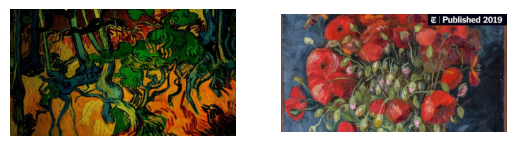

In [82]:
image_index_a = 65  #@param {type: "slider", min: 0, max: 317, step:1}

image_index_b = 86  #@param {type: "slider", min: 0, max: 317, step:1}

embed_a = list(paintings_to_visualize.values())[image_index_a]
embed_b = list(paintings_to_visualize.values())[image_index_b]
#image_a = Image.open(list(paintings_to_visualize.keys())[image_index_a])
#image_b = Image.open(list(paintings_to_visualize.keys())[image_index_b])
image_a_path = f'/content/paintings/{list(paintings_to_visualize.keys())[image_index_a]}'
image_a = Image.open(image_a_path)
image_b_path = f'/content/paintings/{list(paintings_to_visualize.keys())[image_index_b]}'
image_b = Image.open(image_b_path)
print_cosine_similarity(embed_a, embed_b)
show_pair(image_a, image_b)
